In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df['sentiment'] = LabelEncoder().fit_transform(df['sentiment'])

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


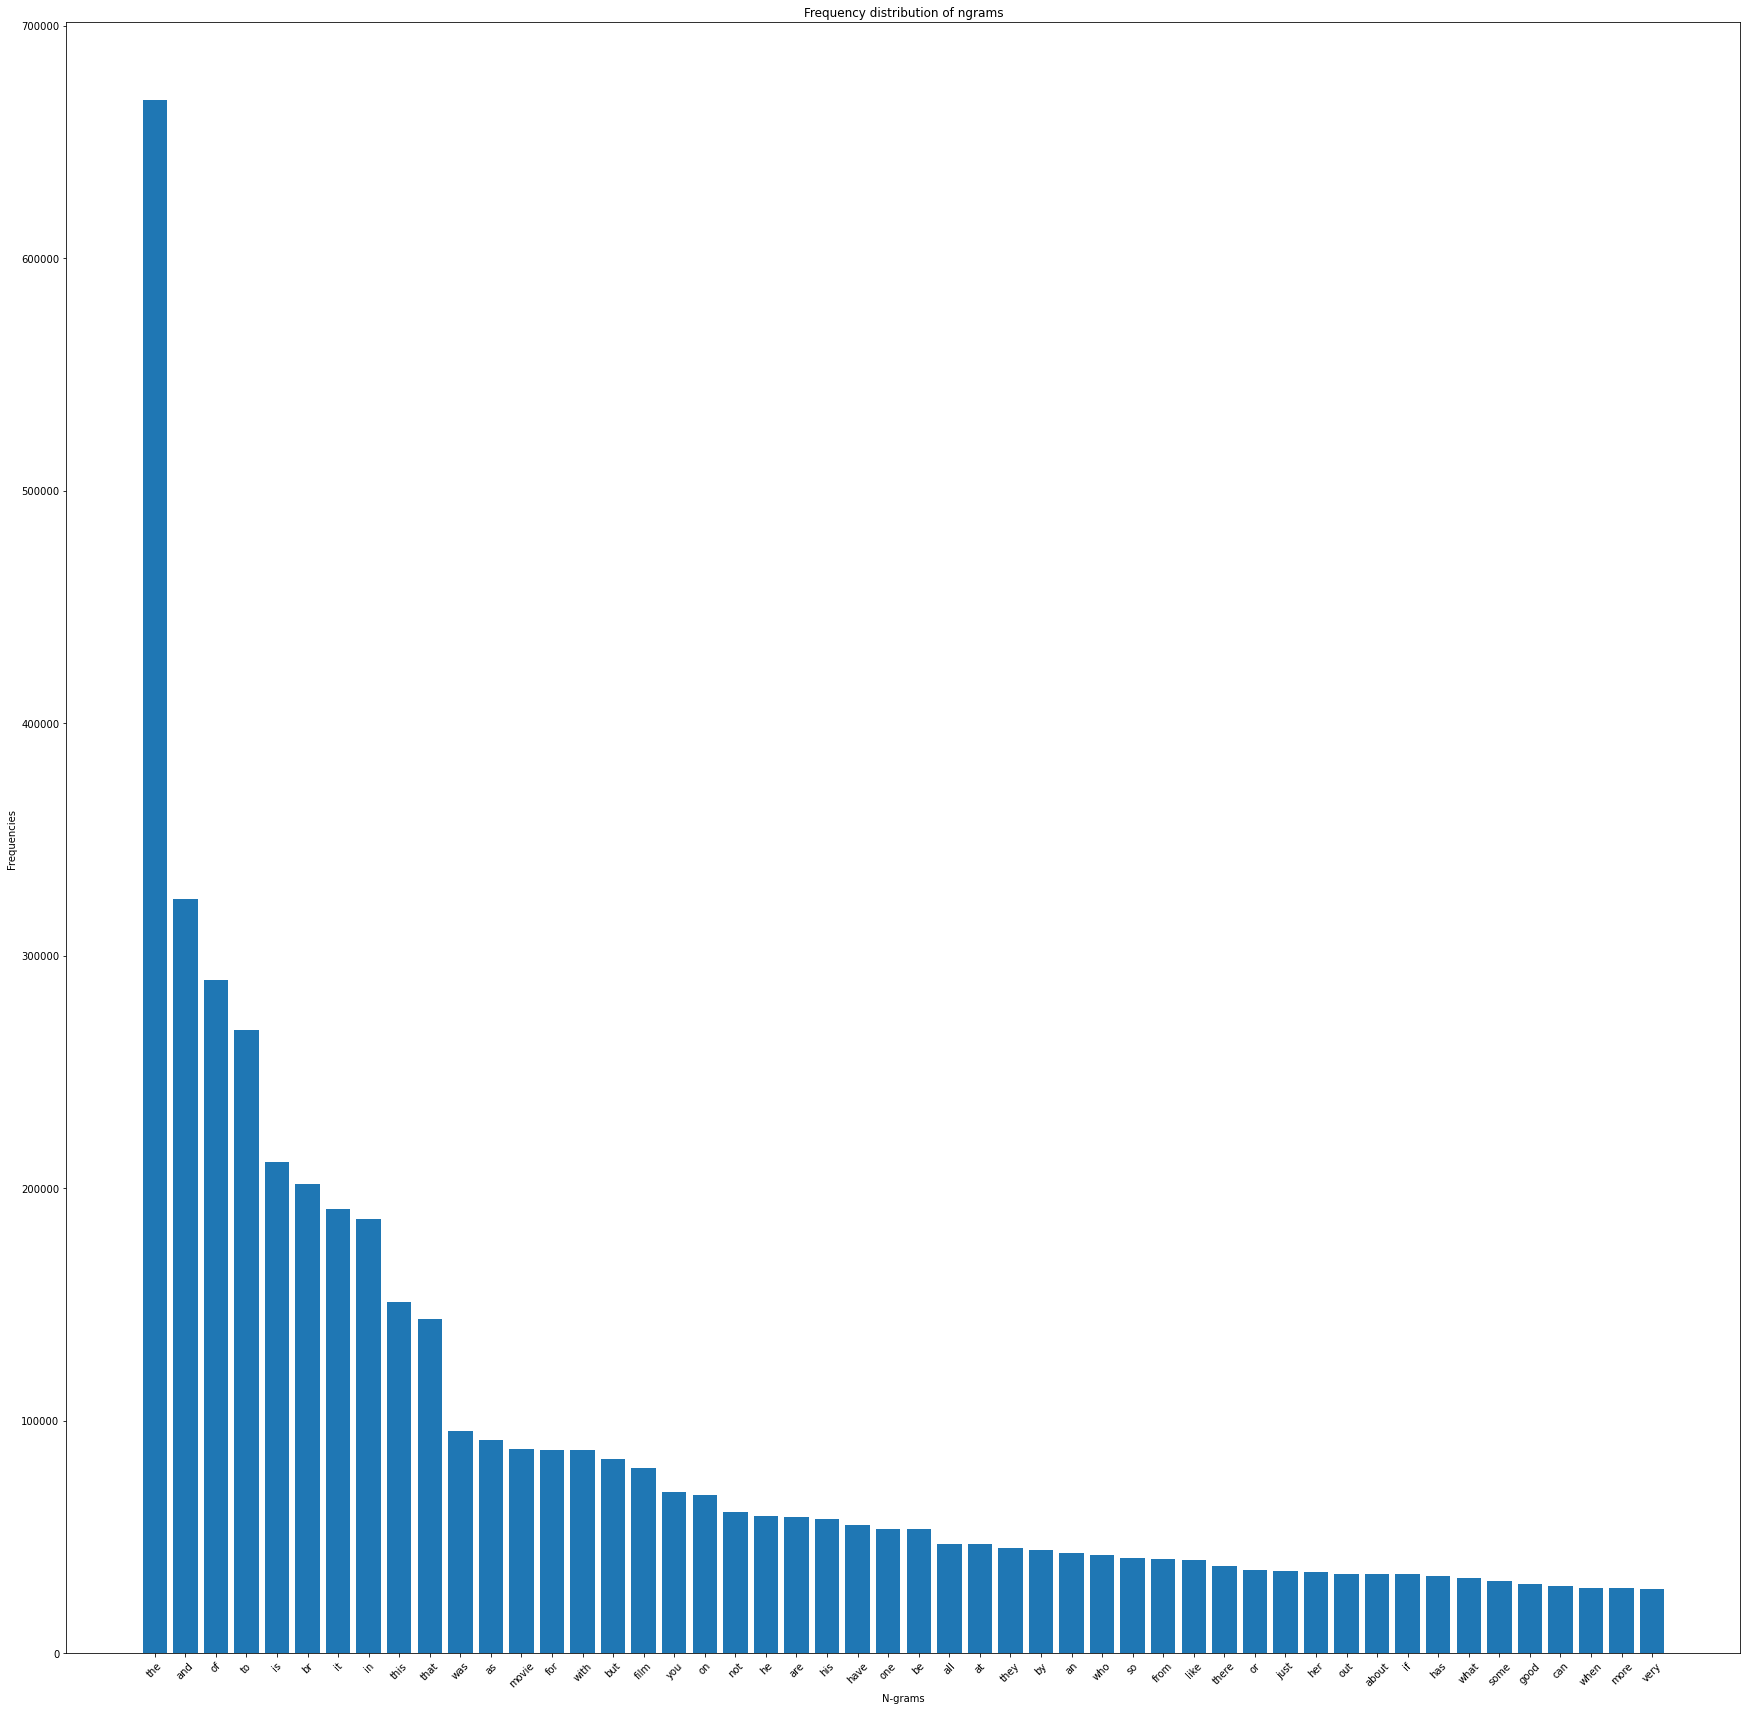

In [6]:
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(df['review']))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)


plt.figure(figsize=(30, 30))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

In [7]:
def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range': (1, 2),
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': 'word',
        'min_df': 2
    }
    
    tfidf_vectorize = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorize.fit_transform(texts)
    
    selector = SelectKBest(f_classif, k=min(20000, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts



In [8]:
vect_data = ngram_vectorize(df['review'], df['sentiment'])

/Users/abdullahalsheeha/opt/anaconda3/envs/myenv3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [9]:
x = vect_data.toarray()
y = (np.array(df['sentiment']))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.2, input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr=0.001),
             metrics=['accuracy'])

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/10
400/400 [==============================] - 6s 16ms/step - loss: 0.3691 - accuracy: 0.8791 - val_loss: 0.2115 - val_accuracy: 0.9184
Epoch 2/10
400/400 [==============================] - 5s 14ms/step - loss: 0.1883 - accuracy: 0.9267 - val_loss: 0.1800 - val_accuracy: 0.9304
Epoch 3/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1459 - accuracy: 0.9454 - val_loss: 0.1749 - val_accuracy: 0.9330
Epoch 4/10
400/400 [==============================] - 5s 12ms/step - loss: 0.1222 - accuracy: 0.9551 - val_loss: 0.1778 - val_accuracy: 0.9336
Epoch 5/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1046 - accuracy: 0.9609 - val_loss: 0.1785 - val_accuracy: 0.9336


In [12]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 3ms/step - loss: 0.1897 - accuracy: 0.9234


[0.18972532451152802, 0.9233999848365784]

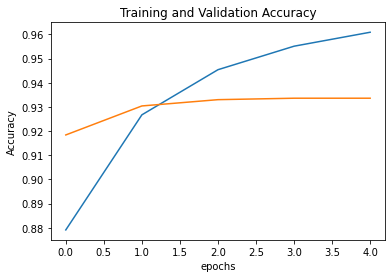

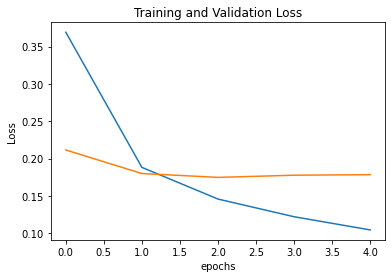

In [13]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    plt.figure(1)
    plt.plot(acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.show()
    
    plt.figure(2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show
    
plot_history(history)    

In [14]:
model.save('Predict_IMDB_reviews.h5')